### Packages loading

In [61]:
import sys
sys.path.insert(0, '..')
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover, utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Quantum architecture search for quantum state preparation problem

This is state preparation circuit which is generated by classical method (amplitude encoding)

Step:   0%|          | 0/2 [31:10<?, ?it/s]


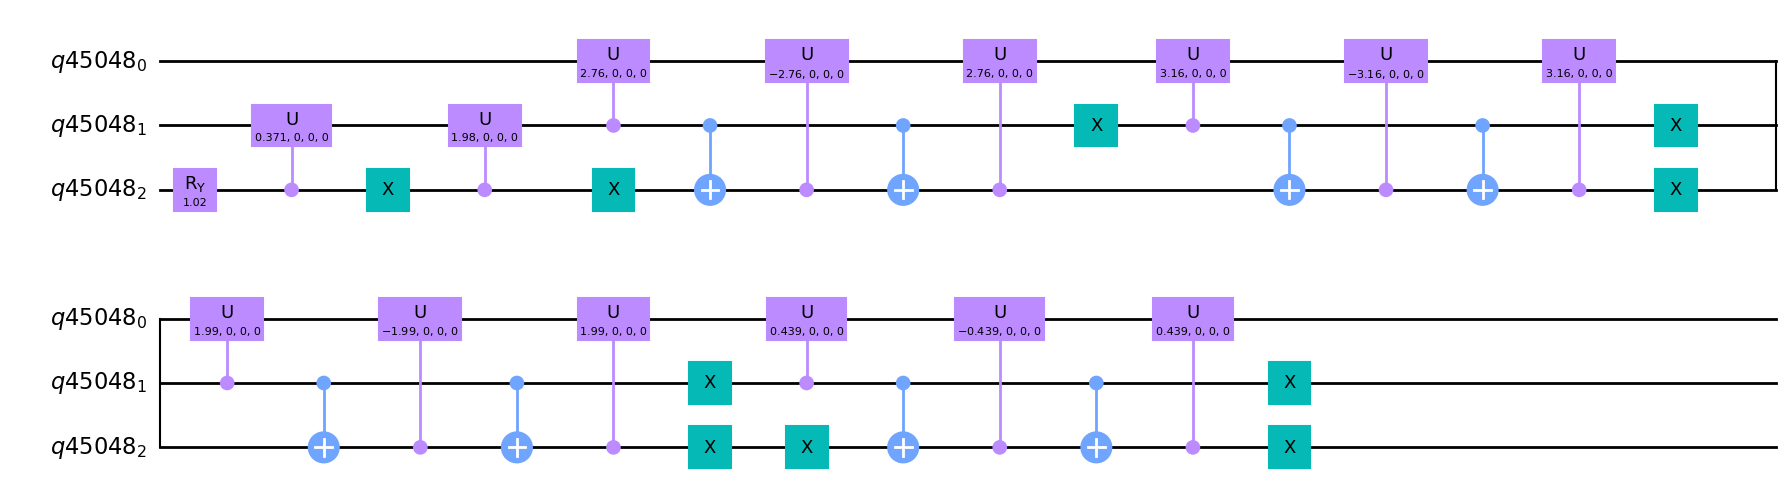

In [8]:
psi = 2*np.random.rand(2**3)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = encoder.qcircuit
qc.draw('mpl')


Now, we defind the problem which is need to solve

In [4]:
qc_haar = qtm.state.create_haar_state_inverse(3)

def compilation_fitness(qc: qiskit.QuantumCircuit, num_steps = 5):
    compiler = qtm.qcompilation.QuantumCompilation(
        u=qc,
        vdagger=qc_haar,
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
    compiler.fit(num_steps=num_steps, verbose=0)
    return np.average(compiler.loss_values)


Main algorithm, includes: init population, selection, crossover, mutate.

In [5]:
params = {'depth': 10,
          'num_individual': 32,  # Must mod 8 = 0
          'num_generation': 30,
          'num_qubits': 3,
          'threshold': lambda loss_value: loss_value < 0.4,
          'prob_mutate': 0.01}

env = environment.EEnvironment(
    params,
    fitness_func = compilation_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qtm.constant.operations
)

env.initialize_population()
env.evol() 

Step:  77%|███████▋  | 23/30 [16:58<05:04, 43.46s/it]

IndexError: list index out of range

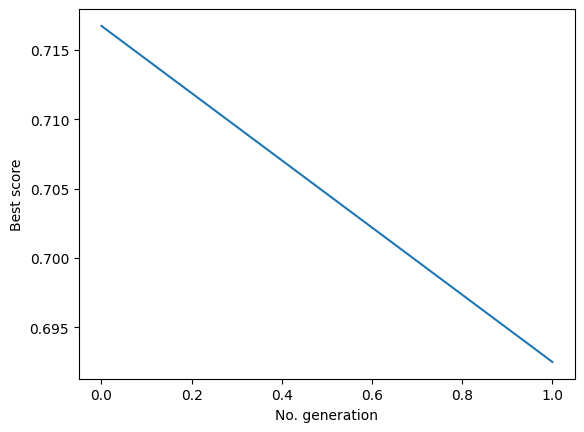

In [ ]:
env.plot()

Test best candidate again

In [ ]:
qc = env.best_candidate.qc
compiler = qtm.qcompilation.QuantumCompilation(
    u=qc,
    vdagger=qc_haar,
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler.fit(num_steps=100, verbose=1)


Step: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


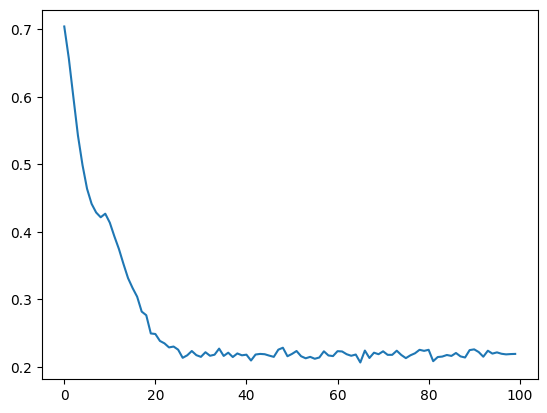

In [23]:
plt.plot(compiler.loss_values)


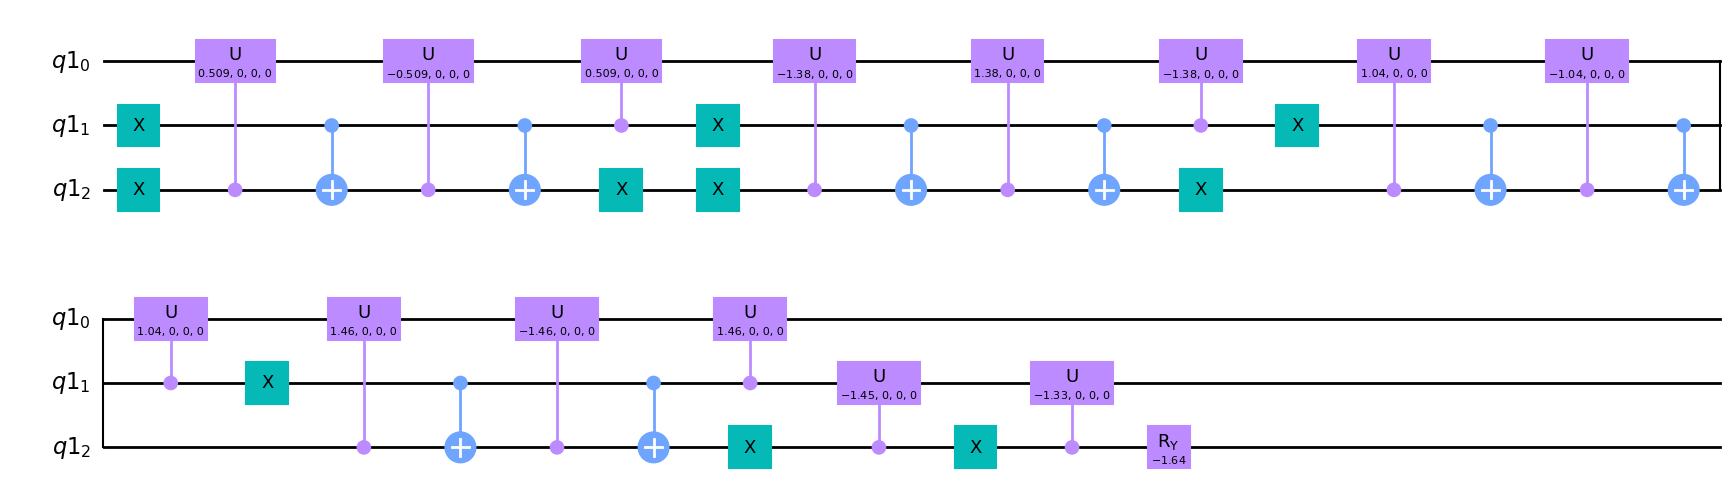

In [24]:
qc_haar.draw('mpl')


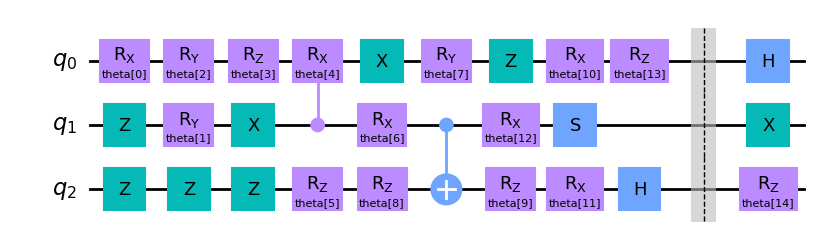

In [25]:
qc.draw('mpl')


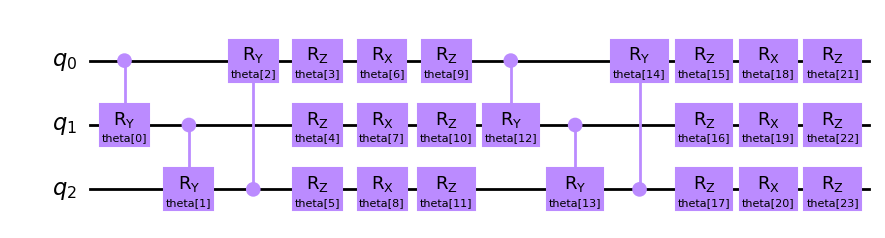

In [13]:
qtm.ansatz.Wchain_ZXZlayer_ansatz(3, 2).draw('mpl')


In [64]:
compiler2 = qtm.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 10),
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    u=qtm.ansatz.create_Wchain_layered_ansatz(3, 1),
    vdagger=qc_haar,
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler2.fit(num_steps=100, verbose=1)


Step: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


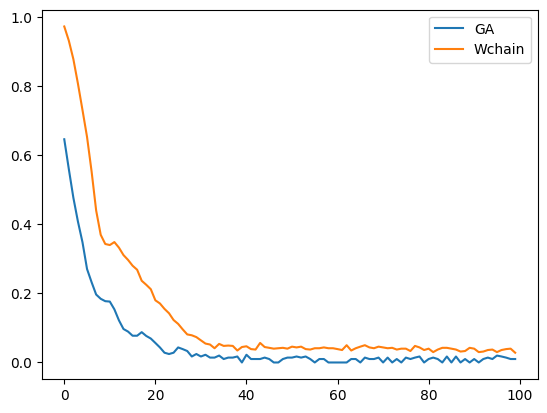

In [88]:
plt.plot(compiler.loss_values, label='GA')
plt.plot(compiler2.loss_values, label='Wchain')
plt.legend()
